In [1]:
import ulmo
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium

In [2]:
%matplotlib inline

In [3]:
# CUAHSI WOF server info
wsdlurl = 'http://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL'

In [4]:
# Obtain SNOTEL info from server
sites = ulmo.cuahsi.wof.get_sites(wsdlurl)

In [5]:
# put into pandas dataframe for ease
sites_df = pd.DataFrame.from_dict(sites,orient='index')
sites_df.head()

,code,name,network,location,elevation_m
SNOTEL:1000_OR_SNTL,1000_OR_SNTL,Annie Springs,SNOTEL,"{'latitude': '42.8701', 'longitude': '-122.1652'}",1831.8
SNOTEL:1001_AK_SNTL,1001_AK_SNTL,Long Lake,SNOTEL,"{'latitude': '58.186', 'longitude': '-133.8322'}",259.1
SNOTEL:1002_AK_SNTL,1002_AK_SNTL,Point Mackenzie,SNOTEL,"{'latitude': '61.3898', 'longitude': '-150.0267'}",76.2
SNOTEL:1003_AK_SNTL,1003_AK_SNTL,Mcneil Canyon,SNOTEL,"{'latitude': '59.7443', 'longitude': '-151.2513'}",402.3
SNOTEL:1004_WA_SNTL,1004_WA_SNTL,Epa Waterhole Can,SNOTEL,"{'latitude': '48.5667', 'longitude': '-123.7'}",1524


In [6]:
# lookup codes for local SNOTEL sites
buckCode = sites_df.code[sites_df.name == 'Buckinghorse'].iloc[0]
wholCode = sites_df.code[sites_df.name == 'Waterhole'].iloc[0]
dungCode = sites_df.code[sites_df.name == 'Dungeness'].iloc[0]
mtcgCode = sites_df.code[sites_df.name == 'Mount Crag'].iloc[0]

In [7]:
# function for extracting SNOTEL info
#Get current datetime
today = datetime.today().strftime('%Y-%m-%d')

def fetch(sitecode, variablecode='SNOTEL:WTEQ_D', start_date='1950-10-01', end_date=today):
    print(sitecode, variablecode, start_date, end_date)
    values_df = None
    try:
        #Request data from the server
        site_values = ulmo.cuahsi.wof.get_values(wsdlurl, sitecode, variablecode, start=start_date, end=end_date)
        #Convert to a Pandas DataFrame   
        values_df = pd.DataFrame.from_dict(site_values['values'])
        #Parse the datetime values to Pandas Timestamp objects
        values_df['datetime'] = pd.to_datetime(values_df['datetime'], utc=True)
        #Set the DataFrame index to the Timestamps
        values_df = values_df.set_index('datetime')
        #Convert values to float and replace -9999 nodata values with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999, np.nan)
        #Remove any records flagged with lower quality
        values_df = values_df[values_df['quality_control_level_code'] == '1']
    except:
        print("Unable to fetch %s" % variablecode)

    return values_df

In [8]:
buckSNO = fetch(buckCode)
wholSNO = fetch(wholCode)
#having problems with this site
#dungSNO = fetch(dungCode)
mtcgSNO = fetch(mtcgCode)

1107_WA_SNTL SNOTEL:WTEQ_D 1950-10-01 2019-03-16
974_WA_SNTL SNOTEL:WTEQ_D 1950-10-01 2019-03-16
648_WA_SNTL SNOTEL:WTEQ_D 1950-10-01 2019-03-16


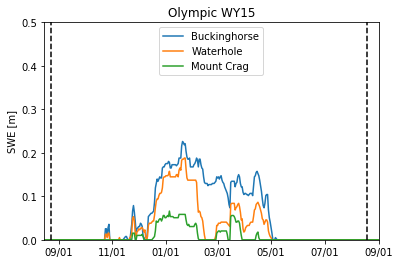

In [9]:
# plot SNOTEL SWE for WY15
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib.dates import DateFormatter

myFmt = DateFormatter("%m/%d") 

f, ax = plt.subplots()
ax.plot(buckSNO.value*0.0254,label='Buckinghorse')
ax.plot(wholSNO.value*0.0254,label='Waterhole')
ax.plot(mtcgSNO.value*0.0254,label='Mount Crag')
ax.plot([pd.Timestamp(2014,8,23),pd.Timestamp(2014,8,23)],\
       [0,0.5],'--k')
ax.plot([pd.Timestamp(2015,8,18),pd.Timestamp(2015,8,18)],\
       [0,0.5],'--k')
ax.set(ylabel="SWE [m]",xlim=(pd.Timestamp(2014,8,15),\
                              pd.Timestamp(2015,9,1)),\
      ylim=(0,0.5))
ax.xaxis.set_major_formatter(myFmt); 
plt.legend()
plt.title('Olympic WY15')

plt.savefig('snotelWY15.png')

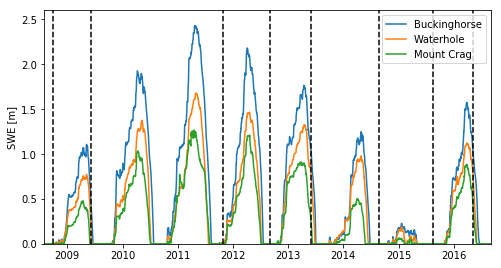

In [10]:
# plot SNOTEL SWE for WY15
#from pandas.plotting import register_matplotlib_converters
#register_matplotlib_converters()
#from matplotlib.dates import DateFormatter

myFmt = DateFormatter("%Y") 

f, ax = plt.subplots()
ax.plot(buckSNO.value*0.0254,label='Buckinghorse')
ax.plot(wholSNO.value*0.0254,label='Waterhole')
ax.plot(mtcgSNO.value*0.0254,label='Mount Crag')
ax.plot([pd.Timestamp(2014,8,23),pd.Timestamp(2014,8,23)],\
       [0,2.6],'--k')
ax.plot([pd.Timestamp(2015,8,18),pd.Timestamp(2015,8,18)],\
       [0,2.6],'--k')
ax.plot([pd.Timestamp(2008,9,26),pd.Timestamp(2008,9,26)],\
       [0,2.6],'--k')
ax.plot([pd.Timestamp(2009,6,4),pd.Timestamp(2009,6,4)],\
       [0,2.6],'--k')
ax.plot([pd.Timestamp(2011,10,27),pd.Timestamp(2011,10,27)],\
       [0,2.6],'--k')
ax.plot([pd.Timestamp(2012,9,1),pd.Timestamp(2012,9,1)],\
       [0,2.6],'--k')
ax.plot([pd.Timestamp(2013,6,3),pd.Timestamp(2013,6,3)],\
       [0,2.6],'--k')
ax.plot([pd.Timestamp(2016,5,7),pd.Timestamp(2016,5,7)],\
       [0,2.6],'--k')
ax.set(ylabel="SWE [m]",xlim=(pd.Timestamp(2008,8,1),\
                              pd.Timestamp(2016,9,1)))
ax.set(ylim=(0,2.6))
ax.xaxis.set_major_formatter(myFmt); 
plt.legend()
f.set_size_inches(8,4.3)

plt.savefig('wholePer.png')

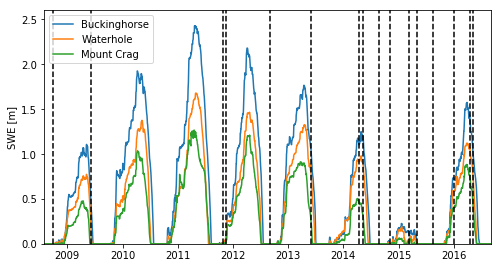

In [11]:
# plot SNOTEL SWE overlaid with all available WV

myFmt = DateFormatter("%Y") 

f, ax = plt.subplots()
ax.plot(buckSNO.value*0.0254,label='Buckinghorse')
ax.plot(wholSNO.value*0.0254,label='Waterhole')
ax.plot(mtcgSNO.value*0.0254,label='Mount Crag')
ax.plot([pd.Timestamp(2014,8,23),pd.Timestamp(2014,8,23)],\
       [0,2.6],'--k')
ax.plot([pd.Timestamp(2014,4,14),pd.Timestamp(2014,4,14)],\
       [0,2.6],'--k')
ax.plot([pd.Timestamp(2014,5,14),pd.Timestamp(2014,5,14)],\
       [0,2.6],'--k')
ax.plot([pd.Timestamp(2014,11,7),pd.Timestamp(2014,11,7)],\
       [0,2.6],'--k')
ax.plot([pd.Timestamp(2015,8,18),pd.Timestamp(2015,8,18)],\
       [0,2.6],'--k')
ax.plot([pd.Timestamp(2008,9,26),pd.Timestamp(2008,9,26)],\
       [0,2.6],'--k')
ax.plot([pd.Timestamp(2009,6,4),pd.Timestamp(2009,6,4)],\
       [0,2.6],'--k')
ax.plot([pd.Timestamp(2011,10,27),pd.Timestamp(2011,10,27)],\
       [0,2.6],'--k')
ax.plot([pd.Timestamp(2011,11,15),pd.Timestamp(2011,11,15)],\
       [0,2.6],'--k')
ax.plot([pd.Timestamp(2012,9,1),pd.Timestamp(2012,9,1)],\
       [0,2.6],'--k')
ax.plot([pd.Timestamp(2013,6,3),pd.Timestamp(2013,6,3)],\
       [0,2.6],'--k')
ax.plot([pd.Timestamp(2016,5,7),pd.Timestamp(2016,5,7)],\
       [0,2.6],'--k')
ax.plot([pd.Timestamp(2016,1,6),pd.Timestamp(2016,1,6)],\
       [0,2.6],'--k')
ax.plot([pd.Timestamp(2016,4,20),pd.Timestamp(2016,4,20)],\
       [0,2.6],'--k')
ax.plot([pd.Timestamp(2015,3,9),pd.Timestamp(2015,3,9)],\
       [0,2.6],'--k')
ax.plot([pd.Timestamp(2015,5,3),pd.Timestamp(2015,5,3)],\
       [0,2.6],'--k')
ax.set(ylabel="SWE [m]",xlim=(pd.Timestamp(2008,8,1),\
                              pd.Timestamp(2016,9,1)))
ax.set(ylim=(0,2.6))
ax.xaxis.set_major_formatter(myFmt); 
plt.legend()
f.set_size_inches(8,4.3)

plt.savefig('wholePer.png')